# GET POSSIBLE FISH FROM SEGMENTED WELL

In [117]:
from src.well.find_well_props import find_well_props
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import scipy
import skimage

from skimage import filters, measure, io, segmentation

## Find well props

In [118]:
from src.InputImage import InputImage

fishy = InputImage('zf2.jpg')

fishy = find_well_props(fishy)

# Find well props
_____________________________________________________________
# Hough-transformation for the well
_____________________________________________________________
# Create circle mask for image
_____________________________________________________________
# Creating mask
_____________________________________________________________
# Get bounding box
_____________________________________________________________


## Initialize start position (OG and Processed) kéne még a mask....

x1: 0,
y1: 0,
x2: 1040,
y2: 1186


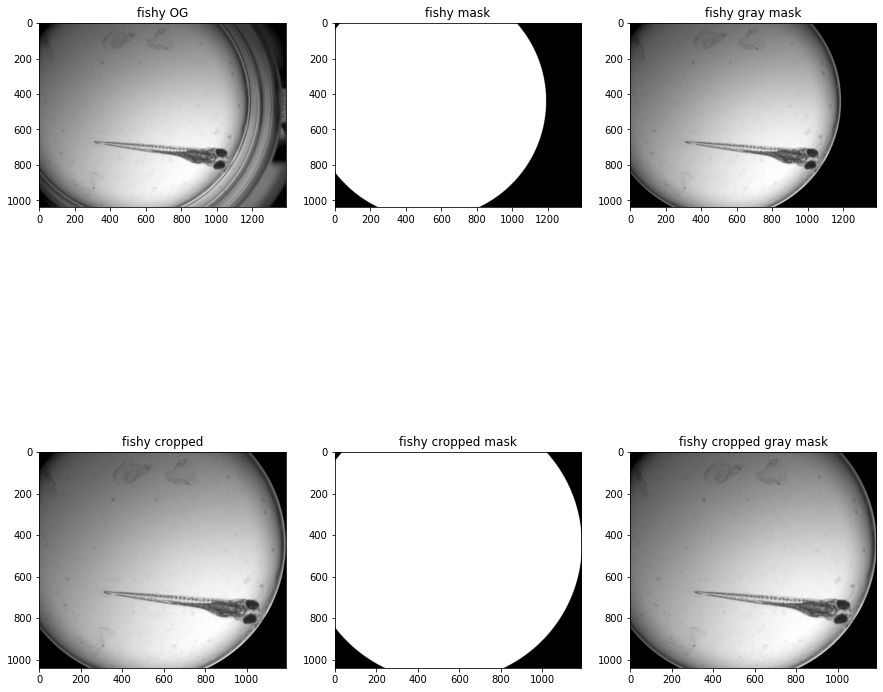

In [119]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 15))

ax[0, 0].imshow(fishy.og, 'gray')
ax[0, 0].set_title('fishy OG')

ax[1, 0].imshow(fishy.processed, 'gray')
ax[1, 0].set_title('fishy cropped')

ax[0, 1].imshow(fishy.well_props.mask.og, 'gray')
ax[0, 1].set_title('fishy mask')

ax[0, 2].imshow(fishy.well_props.mask.gray, 'gray')
ax[0, 2].set_title('fishy gray mask')

ax[1, 2].imshow(fishy.well_props.mask.cropped_gray, 'gray')
ax[1, 2].set_title('fishy cropped gray mask')

ax[1, 1].imshow(fishy.well_props.mask.cropped, 'gray')
ax[1, 1].set_title('fishy cropped mask')

print(fishy.well_props.bounding_box)

plt.show()

## Homomorphic

[[1 1 1]
 [1 1 1]
 [1 1 1]]


(array([ 98095.,  94890.,      0., 210563.,      0.,      0., 390734.,
             0., 239472., 200726.]),
 array([8.10057676e-07, 1.00000729e-01, 2.00000648e-01, 3.00000567e-01,
        4.00000486e-01, 5.00000405e-01, 6.00000324e-01, 7.00000243e-01,
        8.00000162e-01, 9.00000081e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

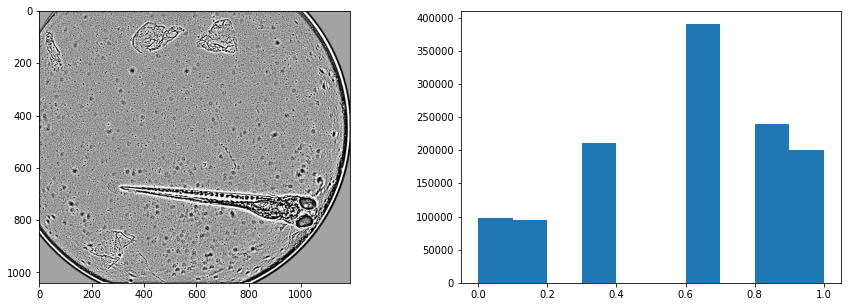

In [134]:
from skimage.morphology import dilation, erosion, square
from skimage.exposure import equalize_hist

img = fishy.well_props.mask.cropped_gray
hpf = img - cv.GaussianBlur(img, (21, 21), 3)+127
equalized = equalize_hist(hpf)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

se = square(3)
print(se)

ax[0].imshow(equalized, 'gray')
ax[1].hist(equalized.ravel())

[[1 1 1]
 [1 1 1]
 [1 1 1]]


(array([  4582.,   4726.,   4545.,   4651.,   5229.,   3887.,   5086.,
             0.,   6680.,      0.,   9171.,      0.,      0.,  15091.,
             0.,      0.,      0.,      0.,      0.,      0.,  34447.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,  94890.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0., 210563.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
      

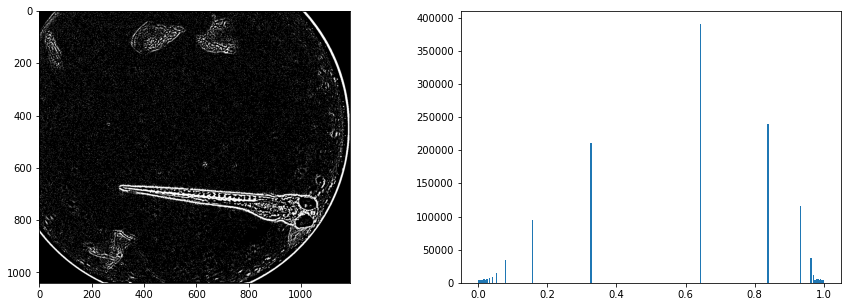

In [147]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

se = square(3)
threshed = (equalized> 0.94).astype(int)
print(se)
ax[0].imshow(threshed, 'gray')
ax[1].hist(equalized.ravel(), bins = 256)

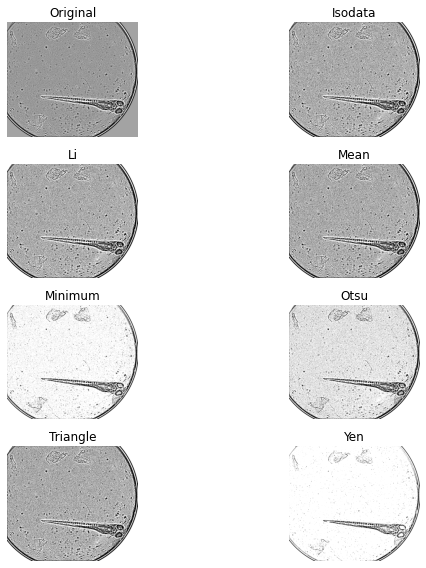

In [150]:
fig, ax = filters.try_all_threshold(equalized, figsize=(10, 8), verbose=False)
plt.show()

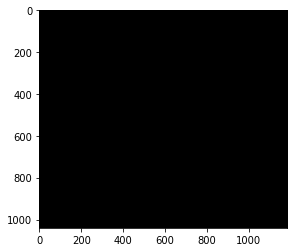

In [148]:

labels = skimage.morphology.label(img)
labelCount = np.bincount(labels.ravel())
background = np.argmax(labelCount)
img[labels != background] = 255
plt.imshow(img, cmap=plt.cm.gray)
plt.show()

## Gamma illumination adjustment
Trying to replace homomorphic filter

Text(0.5, 1.0, 'gamma_low')

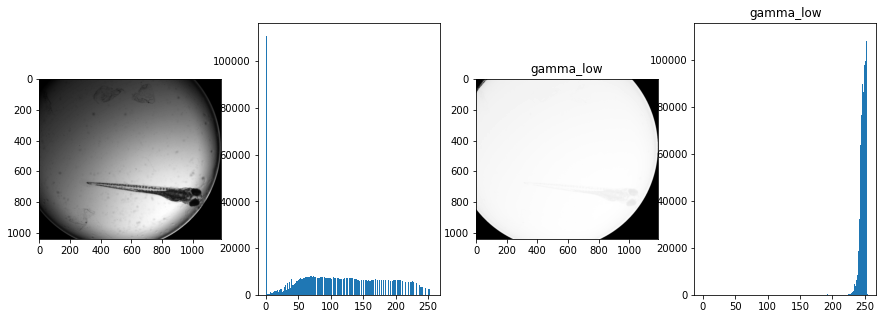

In [121]:
from skimage.exposure import adjust_gamma, adjust_log

data = fishy.processed

gamma_low_val = 0.05
gamma_low = adjust_gamma(data, gamma_low_val)

gamma_high_val = 1.8
gamma_high = adjust_gamma(data, gamma=gamma_high_val)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))

ax[0].imshow(gamma_high, 'gray')
ax[1].hist(gamma_high.ravel(), bins= 256)
ax[2].imshow(gamma_low, 'gray')
ax[2].set_title('gamma_low')

ax[3].hist(gamma_low.ravel(), bins= 256)
ax[3].set_title('gamma_low')